<h1>Comparison of genesets with and without all eQTLs and eQTLs in open chromatine</h1>

In [1]:
import scdrs
import scanpy as sc
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib_venn import venn3
import seaborn as sns
from functools import reduce

In [2]:
data_dir = Path("../Data")

gene_ref_file = data_dir / "Reference/GRCh38/LimixAnnotationFile.txt"

g_sets_dir = data_dir / "SCDRS" / "genesets"
g_scores_dir = data_dir / "PascalX" / "gene_scores"

all_mono_gs_paths = {
    "eqtl" : g_scores_dir / "all_eqtls" / "Mono_count_GWAS_gscores.tsv",
    "eqtl_oc" : g_scores_dir / "oc_eqtls" / "Mono_count_GWAS_gscores.tsv",
    "baseline" :g_scores_dir / "window_10000"/ "Mono_count_GWAS_gscores.tsv"
}

# Genesets (top 1000 genes, processed by scDRS munge-gs)
t1k_mono_gs_paths = {
    "eqtl" : g_sets_dir / "eqtl" / "px_mono_count_eqtl.gs",
    "baseline" : g_sets_dir /  "px_mono_count_w10kb.gs",
    "eqtl_oc" : g_sets_dir / "eqtl_oc" / "px_mono_count_eqtl_oc.gs" 
}

# Read gene reference
gene_ref_df = pd.read_csv(gene_ref_file, sep="\t")


<h2> Number of SNPs per trait (baseline and baseline + eQTLs)

In [29]:
gene_data = {
    "eqtls": {},
    "base": {}
}

for folder in g_scores_dir.iterdir():
    if folder.is_dir():
        if folder.name == "all_eqtls":
            for file in folder.iterdir():
                if file.name.endswith(".tsv"):
                    df = pd.read_csv(file, sep="\t")  
                    name = file.name.split(".")[0]
                    gene_data["eqtls"][name] = df

        elif folder.name == "window_10000":
            for file in folder.iterdir():
                if file.name.endswith(".tsv"):
                    df = pd.read_csv(file, sep="\t")  
                    name = file.name.split(".")[0]
                    gene_data["base"][name] = df


In [30]:
snp_count_differences = {}

for name in gene_data["eqtls"]:
    if name in gene_data["base"]:
        eqtl_df = gene_data["eqtls"][name]
        base_df = gene_data["base"][name]

        if "nsnps" in eqtl_df.columns and "nsnps" in base_df.columns:
            eqtl_sum = eqtl_df["nsnps"].sum()
            base_sum = base_df["nsnps"].sum()
            snp_count_differences[name] = eqtl_sum - base_sum
        else:
            print(f"Warning: 'nsnps' column missing in {name}")
    else:
        print(f"Warning: {name} not found in base data")

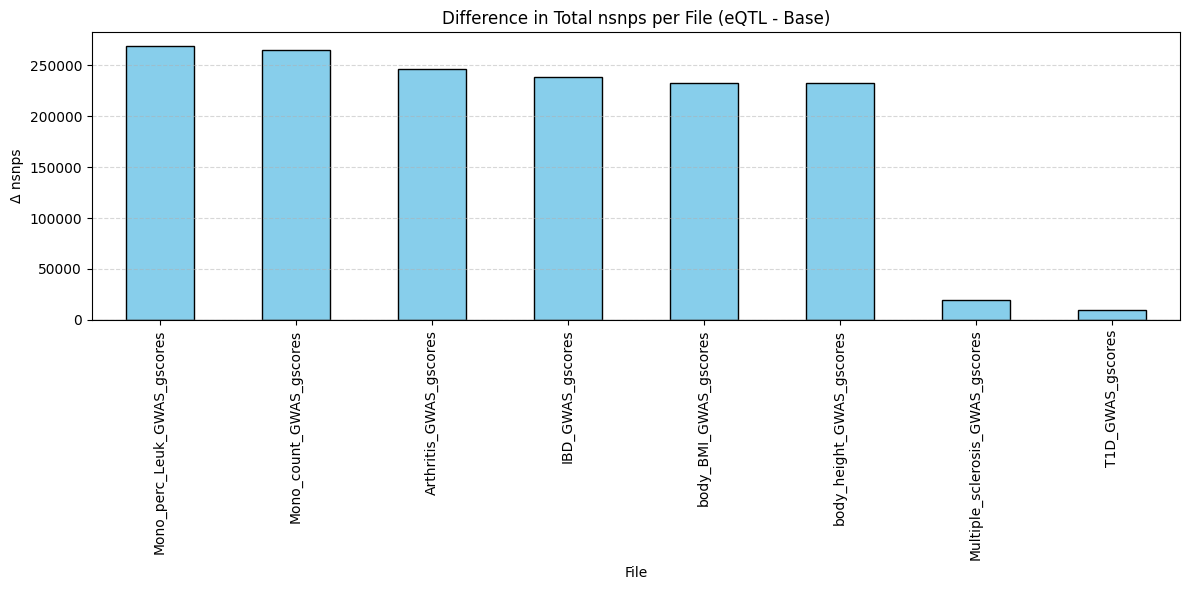

In [31]:
# Convert to DataFrame for easier plotting
df_diffs = pd.DataFrame.from_dict(snp_count_differences, orient="index", columns=["nsnps_diff"])
df_diffs = df_diffs.sort_values("nsnps_diff", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
df_diffs["nsnps_diff"].plot(kind="bar", color="skyblue", edgecolor="black")

plt.title("Difference in Total nsnps per File (eQTL - Base)")
plt.ylabel("Δ nsnps")
plt.xlabel("File")
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.axhline(0, color="gray", linewidth=1)

plt.show()

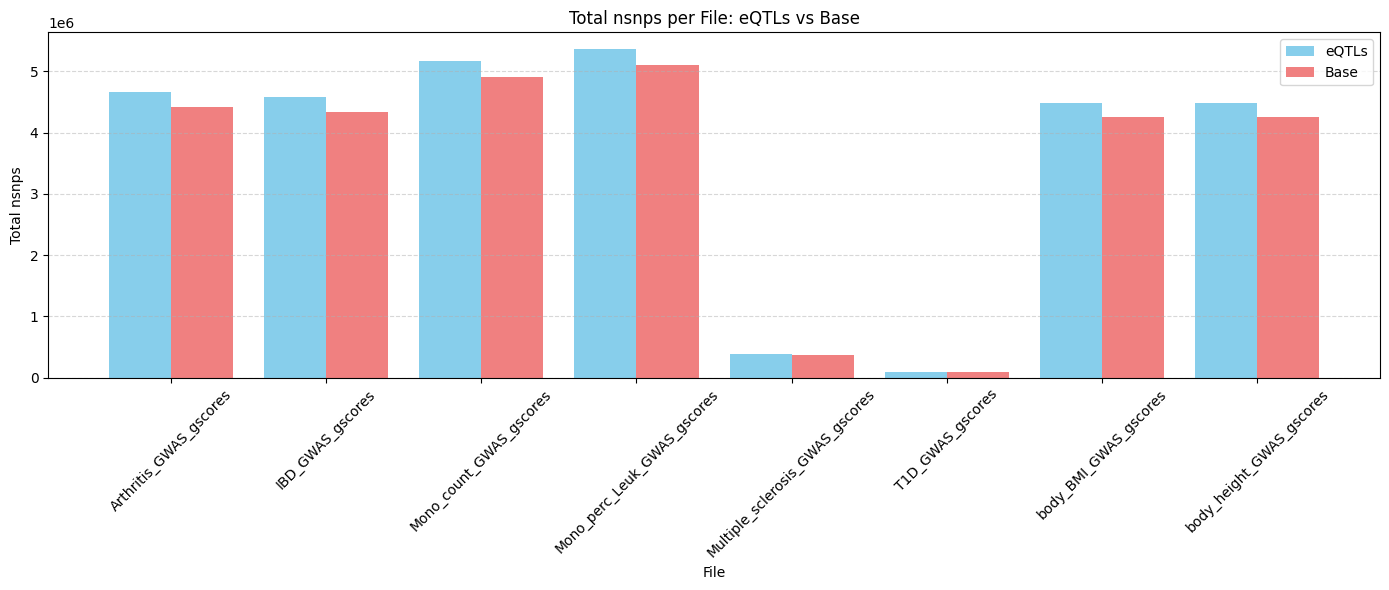

In [21]:
# Collect total nsnps counts
totals = []

for name in gene_data["eqtls"]:
    if name in gene_data["base"]:
        eqtl_df = gene_data["eqtls"][name]
        base_df = gene_data["base"][name]

        if "nsnps" in eqtl_df.columns and "nsnps" in base_df.columns:
            eqtl_sum = eqtl_df["nsnps"].sum()
            base_sum = base_df["nsnps"].sum()
            totals.append((name, eqtl_sum, base_sum))

# Create DataFrame
df_totals = pd.DataFrame(totals, columns=["file", "eqtls", "base"]).set_index("file")
df_totals = df_totals.sort_index()

# Plot grouped bars
x = range(len(df_totals))
width = 0.4

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], df_totals["eqtls"], width=width, label="eQTLs", color="skyblue")
plt.bar([i + width/2 for i in x], df_totals["base"], width=width, label="Base", color="lightcoral")

plt.xticks(x, df_totals.index, rotation=45)
plt.xlabel("File")
plt.ylabel("Total nsnps")
plt.title("Total nsnps per File: eQTLs vs Base")
plt.legend()
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

<h2> eQTL and CRE stats

In [6]:
all_eqtls_file = data_dir / "ATAC/unmapped_snps/eqtls.bed"
oc_eqtls_file = data_dir / "ATAC/mapped_snps/oc_eqtl_intersect_mono.tsv"

all_eqtls = pd.read_csv(all_eqtls_file, sep="\t")
oc_eqtls = pd.read_csv(oc_eqtls_file, sep="\t")


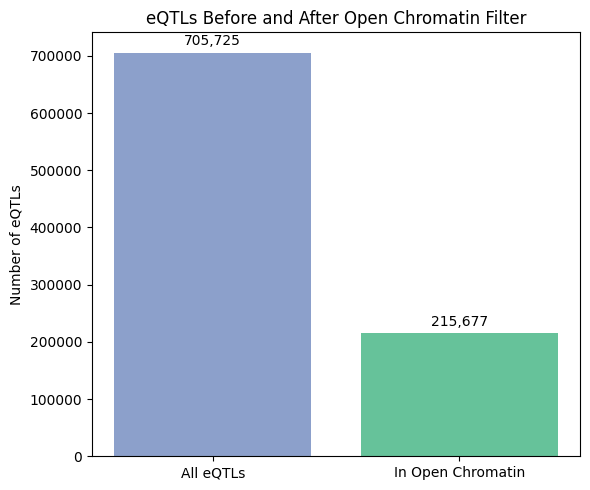

In [7]:
# Counts
counts = [len(all_eqtls), len(oc_eqtls)]
labels = ['All eQTLs', 'In Open Chromatin']

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=['#8CA0CB', '#66C29A'])
plt.ylabel('Number of eQTLs')
plt.title('eQTLs Before and After Open Chromatin Filter')

# Annotate counts on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01 * max(counts),
             f'{height:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


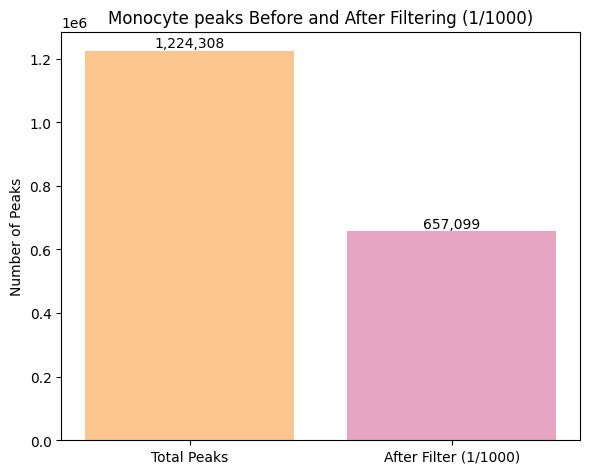

In [23]:
counts = [1224308, 657099]
labels = ['Total Peaks', 'After Filter (1/1000)']

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=['#FBC58E', '#E6A6C3'])
plt.ylabel('Number of Peaks')
plt.title('Monocyte peaks Before and After Filtering (1/1000)')

# Annotate counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1000, f'{height:,}', 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

<h2>Monocyte count</h2>

In [15]:
# Initialize dict
all_mono_gs = {}
t1k_mono_gs = {}

# All PascalX gene scores
for gs_name, file_path in all_mono_gs_paths.items():
    df = pd.read_csv(file_path, sep="\t")
    merged_df = df.merge(
        gene_ref_df[['feature_id', 'start', 'end', 'chromosome']],
        left_on="gene",
        right_on="feature_id",
        how="left"
    )
    all_mono_gs[gs_name] = merged_df

# Read and process genesets (top 1000 genes)
for gs_name, file_path in t1k_mono_gs_paths.items():
    with open(file_path) as f:
        f.readline()
        data = f.readline().split()[1].split(",")
        gene_scores = [(gene.strip(), float(z)) for gene_data in data if gene_data for gene, z in [gene_data.split(":")]]
        
        df = pd.DataFrame(gene_scores, columns=['gene', 'z_score'])
        merged = df.merge(gene_ref_df, left_on="gene", right_on="feature_id", how="left")

        t1k_mono_gs[gs_name] = merged[[ "gene", "ENSG", "z_score", "chromosome", "start" ]]

t1k_mono_gs["eqtl"]

,gene,ENSG,z_score,chromosome,start
0,LINC01565,ENSG00000198685,10.0000,3,128572000
1,AC092723.5,ENSG00000285163,10.0000,16,85924984
2,RPN1,ENSG00000163902,10.0000,3,128619970
3,IRF8,ENSG00000140968,10.0000,16,85898803
4,AC092723.4,ENSG00000285040,10.0000,16,85963328
...,...,...,...,...,...
995,NLRX1,ENSG00000160703,7.8821,11,119166568
996,AL031118.1,ENSG00000271755,7.8778,6,27404010
997,GPX5,ENSG00000224586,7.8778,6,28525925
998,AC011840.3,ENSG00000263860,7.8778,17,30550493


<h3> Number of SNPs per gene</h3>

In [16]:
all_mono_gs["eqtl"].head()

,gene,pvalue,nsnps,min_pvalue,feature_id,start,end,chromosome
0,OR4F5,0.584408,5,0.25,OR4F5,65419,71585,1
1,AL627309.1,0.066156,3,0.08,AL627309.1,89295,133723,1
2,AL627309.3,0.330000,1,0.33,AL627309.3,89551,91105,1
3,AL627309.2,0.090000,1,0.09,AL627309.2,139790,140339,1
4,AC114498.1,0.210000,1,0.21,AC114498.1,587629,594768,1


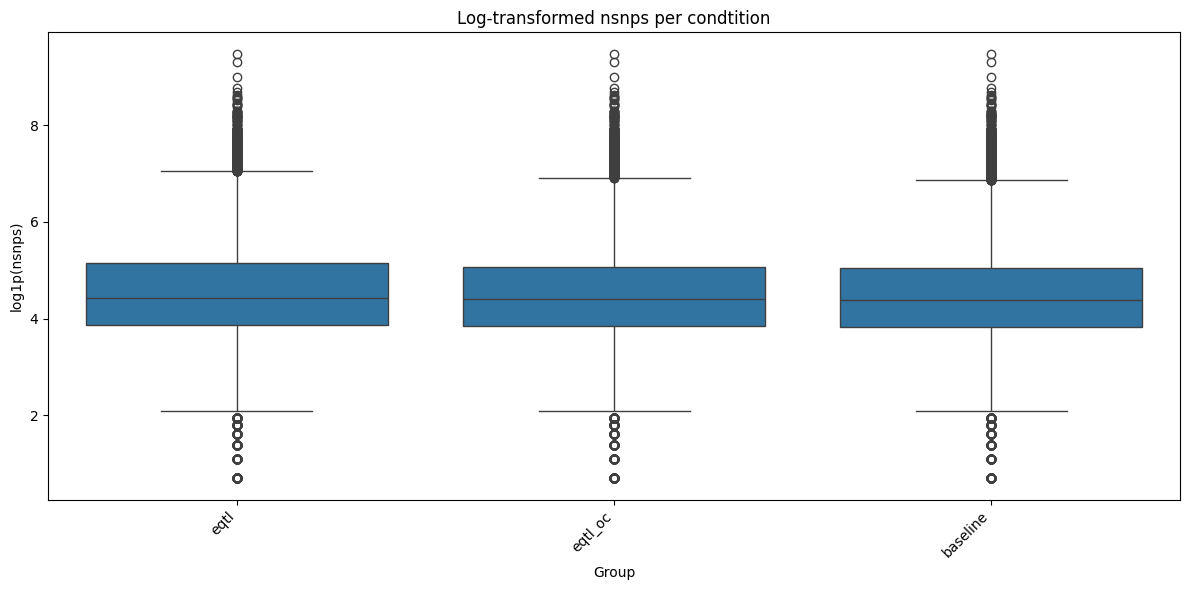

In [9]:
# Prepare combined DataFrame
combined_data = []

for name, df in all_mono_gs.items():
    if "nsnps" in df.columns:
        temp_df = pd.DataFrame({
            'log_nsnps': np.log1p(df['nsnps']),
            'Group': name
        })
        combined_data.append(temp_df)

# Combine all into one DataFrame
plot_df = pd.concat(combined_data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Group', y='log_nsnps')
plt.xticks(rotation=45, ha='right')
plt.ylabel('log1p(nsnps)')
plt.title('Log-transformed nsnps per condtition')
plt.tight_layout()
plt.show()

/local/1287192/ipykernel_1659325/3046426526.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


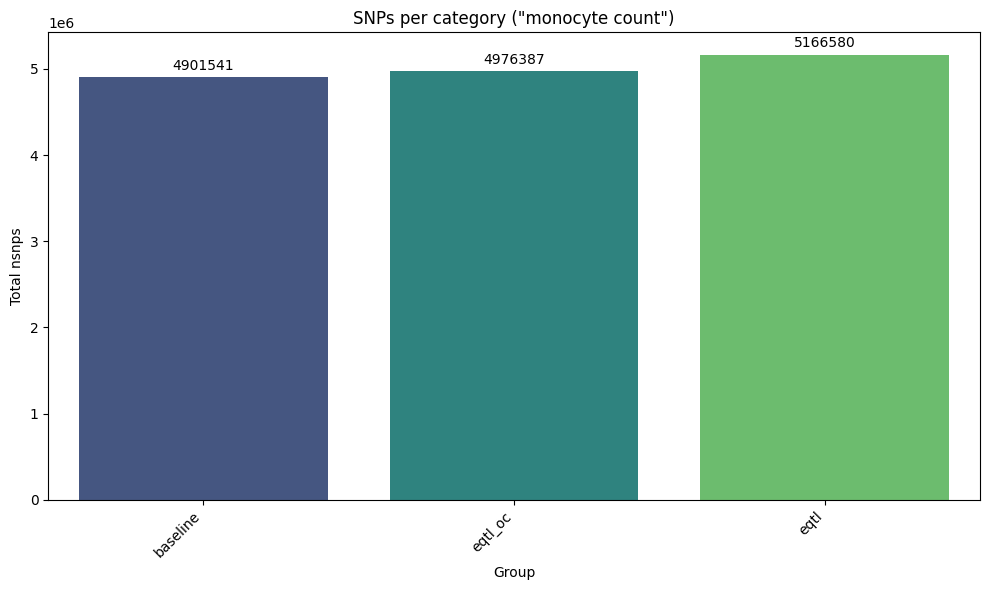

In [18]:
# Calculate the sum of nsnps per group
nsnps_sums = {
    name: df['nsnps'].sum()
    for name, df in all_mono_gs.items()
    if 'nsnps' in df.columns
}

# Create a DataFrame from the dictionary and sort by value
nsnps_sums_df = pd.DataFrame.from_dict(nsnps_sums, orient='index', columns=['sum_nsnps'])
nsnps_sums_df = nsnps_sums_df.sort_values(by='sum_nsnps', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=nsnps_sums_df.reset_index(),
    y='sum_nsnps', x='index',
    palette='viridis'
)

# Add total count labels on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', padding=3)

plt.xlabel('Group')
plt.ylabel('Total nsnps')
plt.title('SNPs per category ("monocyte count")')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


In [22]:
for name, df in all_mono_gs.items():
    print(name)
    print(df['nsnps'].describe())
    print(df['nsnps'].median())

eqtl
count    31478.000000
mean       164.133045
std        296.617750
min          1.000000
25%         47.000000
50%         83.000000
75%        170.000000
max      13104.000000
Name: nsnps, dtype: float64
83.0
eqtl_oc
count    31475.000000
mean       158.106021
std        293.027580
min          1.000000
25%         46.000000
50%         81.000000
75%        159.000000
max      13104.000000
Name: nsnps, dtype: float64
81.0
baseline
count    31471.000000
mean       155.747863
std        292.515482
min          1.000000
25%         45.000000
50%         79.000000
75%        154.000000
max      13104.000000
Name: nsnps, dtype: float64
79.0


<h3>Number of SNPs per gene top 1000</h3>

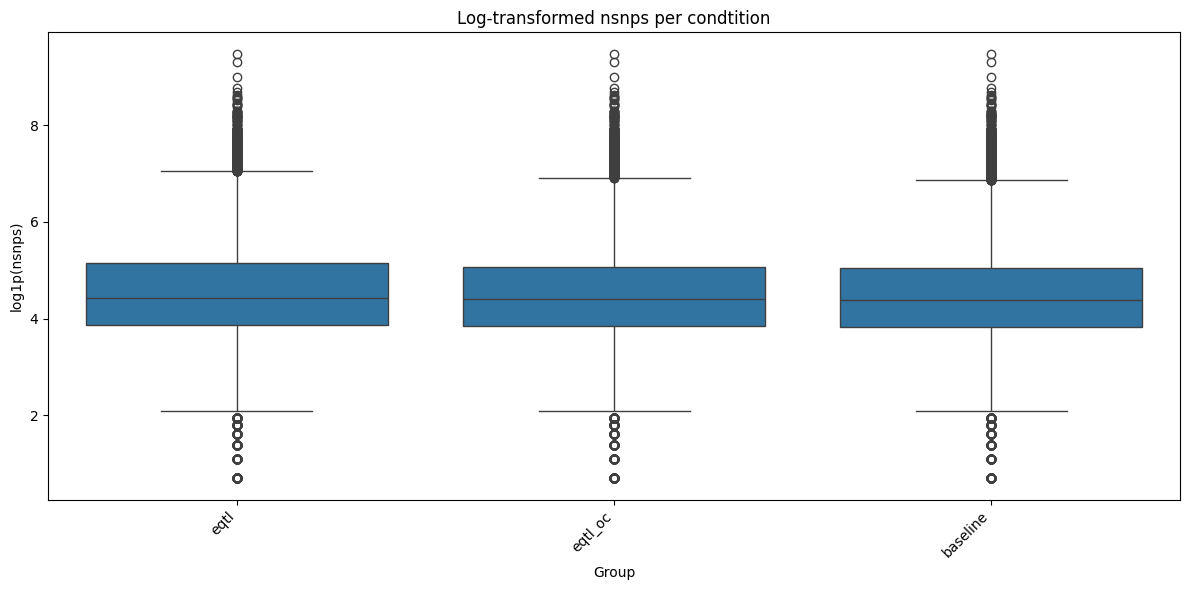

In [11]:
# Prepare combined DataFrame
combined_data = []

for condition, df in t1k_mono_gs.items():
    condition_all = all_mono_gs[condition][["gene", "nsnps"]].copy()
    
    # df["nsnps"] = 

for name, df in all_mono_gs.items():
    if "nsnps" in df.columns:
        temp_df = pd.DataFrame({
            'log_nsnps': np.log1p(df['nsnps']),
            'Group': name
        })
        combined_data.append(temp_df)

# Combine all into one DataFrame
plot_df = pd.concat(combined_data, ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=plot_df, x='Group', y='log_nsnps')
plt.xticks(rotation=45, ha='right')
plt.ylabel('log1p(nsnps)')
plt.title('Log-transformed nsnps per condtition')
plt.tight_layout()
plt.show()

<h3> Distribution of gene signal

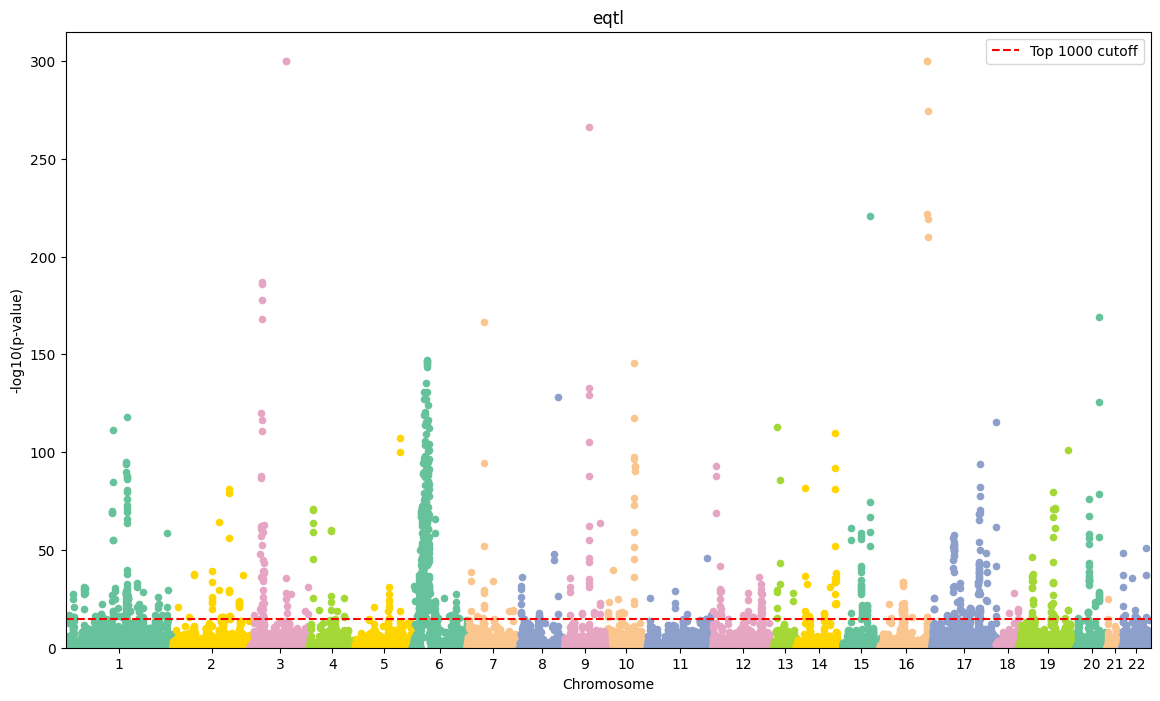

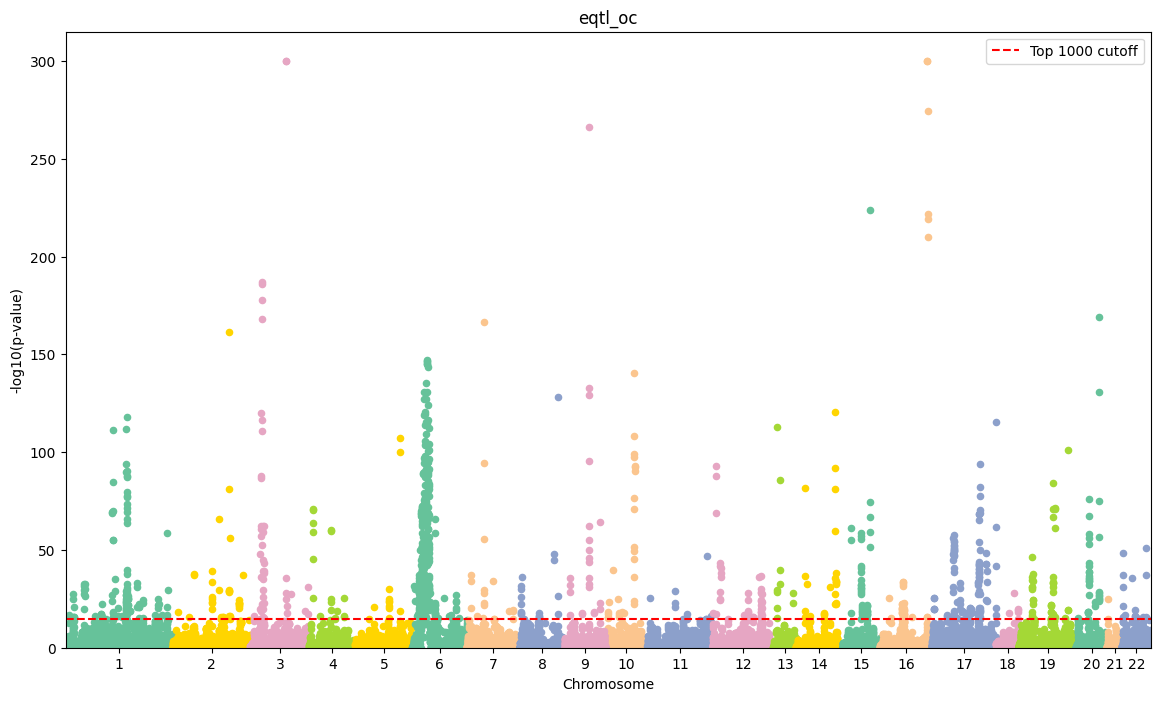

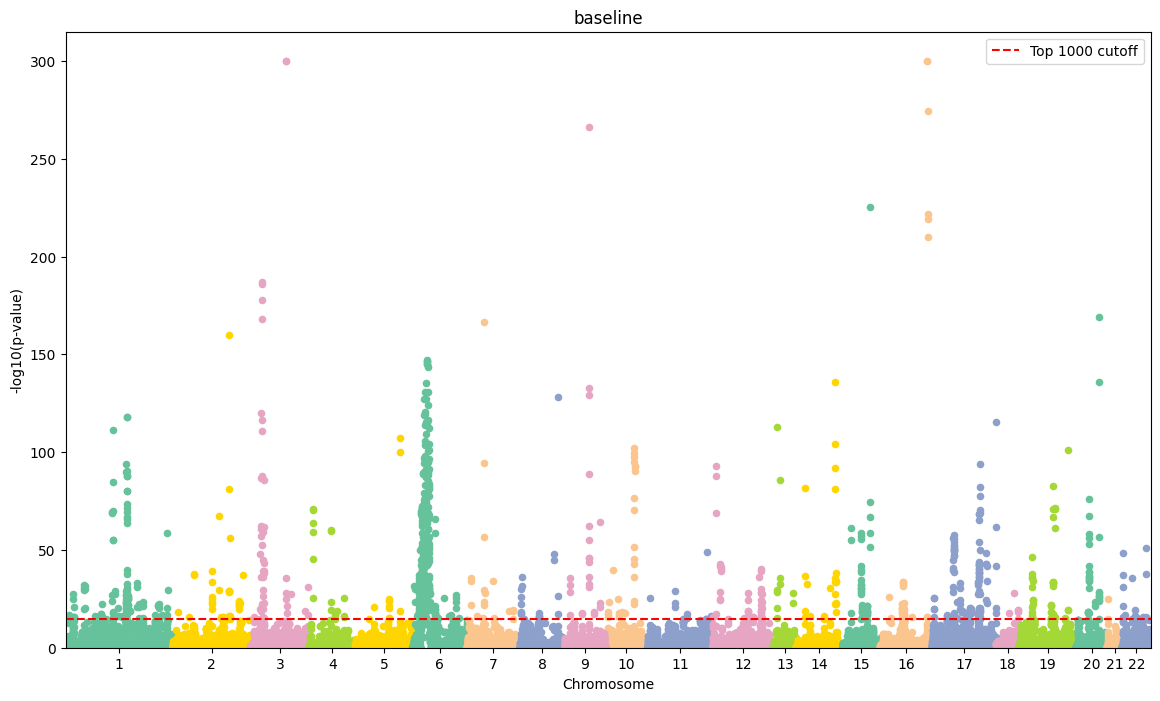

In [29]:
# Manhattan plots
colors = [
    "#66C29A",  # light green
    "#FBC58E",  # warm orange
    "#8CA0CB",  # light blue
    "#E6A6C3",  # light pink
    "#A4D836",  # light lime
    "#FFD500"   # golden yellow
]

for gs, df in all_mono_gs.items():
    
    # -log10(P)
    df['-log10(P)'] = -np.log10(df['pvalue'])
    
    # Calculate cutoff: -log10 of 1000th smallest p-value
    sorted_pvals = df['pvalue'].nsmallest(1000)
    cutoff_line = -np.log10(sorted_pvals.max())  # max of top 1000 = 1000th lowest

    # Create a cumulative position
    df['ind'] = range(len(df))
    df_grouped = df.groupby('chromosome')
    
    # Plot
    fig = plt.figure(figsize=(14, 8)) 
    ax = fig.add_subplot(111)
    x_labels = []
    x_labels_pos = []
    
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='-log10(P)', color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)
    
    ax.axhline(y=cutoff_line, color='red', linestyle='--', linewidth=1.5, label='Top 1000 cutoff')
    
    ax.set_xlim(df['ind'].iloc[0], df['ind'].iloc[-1])
    ax.set_ylim(bottom=0)
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(p-value)')
    plt.title(gs)
    ax.legend()
    plt.show()



<h2>Geneset stats</h2>

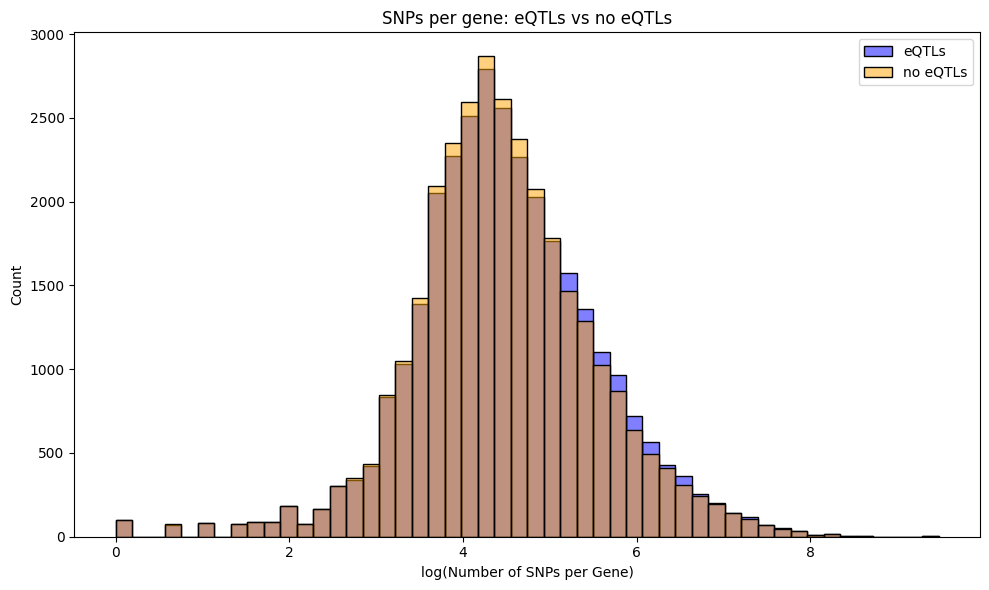

In [4]:
plt.figure(figsize=(10, 6))

sns.histplot(np.log(eqtl_gene_scores['nsnps']), bins=50, color='blue', label='eQTLs', alpha=0.5)
sns.histplot(np.log(eqtl_oc_gene_scores['nsnps']), bins=50, color='orange', label='no eQTLs', alpha=0.5)

plt.xlabel('log(Number of SNPs per Gene)')
plt.ylabel('Count')
plt.title('SNPs per gene: eQTLs vs no eQTLs')
plt.legend()
plt.tight_layout()
plt.show()

<H2> Gene discrepancies

/groups/umcg-franke-scrna/tmp02/users/umcg-hdijkstra/scscore/lib64/python3.9/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning: Bad circle positioning.
  warnings.warn("Bad circle positioning.")


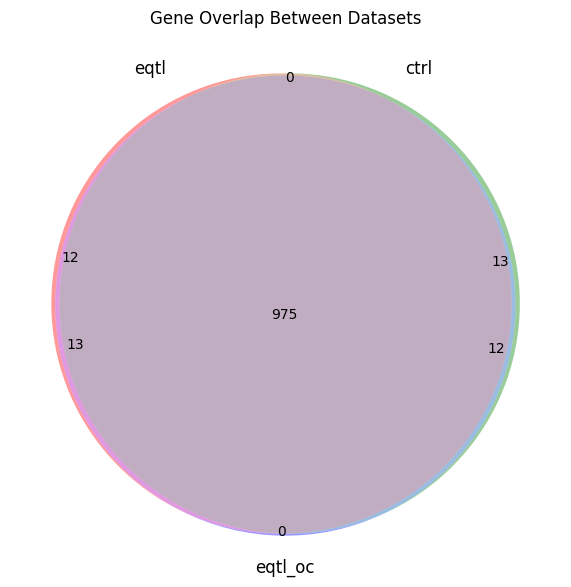

In [4]:
# Extract sets of genes from each DataFrame
genes1 = set(mono_gs_data["eqtl"]["gene"])
genes2 = set(mono_gs_data["ctrl"]["gene"])
genes3 = set(mono_gs_data["eqtl_oc"]["gene"])
# Make the Venn diagram
plt.figure(figsize=(8, 6))
venn3([genes1, genes2, genes3], set_labels=("eqtl", "ctrl", "eqtl_oc"))
plt.title("Gene Overlap Between Datasets")
plt.tight_layout()
plt.show()


In [38]:
eqtl_genes = list(mono_gs_data["eqtl"]["gene"])
ctrl_genes = list(mono_gs_data["ctrl"]["gene"])
eqtl_oc_genes = list(mono_gs_data["eqtl_oc"]["gene"])

dicrepant_oc_eqtl = [gene for gene in eqtl_oc_genes if gene not in ctrl_genes]
dicrepant_eqtl = [gene for gene in eqtl_genes if gene not in ctrl_genes]
discrepant = [gene for gene in eqtl_genes if gene not in eqtl_oc_genes]

In [39]:
# Select and rename only the necessary columns
eqtl = mono_gs_data["eqtl"][["gene", "z_score"]].rename(columns={"z_score": "eqtl_score"})
ctrl = mono_gs_data["ctrl"][["gene", "z_score"]].rename(columns={"z_score": "ctrl_score"})
eqtl_oc = mono_gs_data["eqtl_oc"][["gene", "z_score"]].rename(columns={"z_score": "eqtl_oc_score"})

# Merge just on 'gene'
merged = eqtl.merge(ctrl, on="gene", how="outer").merge(eqtl_oc, on="gene", how="outer")

# View result
print(merged.head())
print(len(merged))


     gene  eqtl_score  ctrl_score  eqtl_oc_score
0    AAMP      9.9023      9.9023         9.9023
1  ABALON      8.8742      8.8742         8.8742
2   ABCE1      8.2873      8.2873         8.2873
3   ABCF1     10.0000     10.0000        10.0000
4  ABHD15     10.0000     10.0000        10.0000
1025


In [26]:
merged["score_diff"] = merged["eqtl_score"] - merged["ctrl_score"]

# Sort by largest differences
discrepant = merged.sort_values(by="score_diff", key=abs, ascending=False)

print(discrepant[1:25])

         gene  eqtl_score  ctrl_score  eqtl_oc_score  score_diff
552      IRF1     10.0000      7.9427        10.0000      2.0573
620      LSM4     10.0000      7.9886        10.0000      2.0114
137      AHI1      8.1613     10.0000        10.0000     -1.8387
844     SH2B3      8.4459     10.0000        10.0000     -1.5541
573     KLRC3      8.4618     10.0000        10.0000     -1.5382
481       HCK     10.0000      8.6655        10.0000      1.3345
978     XRCC3     10.0000      8.8304        10.0000      1.1696
878       SRR      9.2674      8.2035         9.1542      1.0639
291    CACFD1      8.5125      9.5153         9.2553     -1.0028
963     USP49     10.0000      9.1072         9.6993      0.8928
370     DAGLB      8.9128      9.7281         9.3598     -0.8153
637       LYZ      8.0431      8.8365         8.8549     -0.7934
973      WNK1      8.9155      8.1465         8.6974      0.7690
683     NAA25      8.7259      7.9732         8.3551      0.7527
674      MTF2      8.7999

In [31]:
cov_matrix = merged[["eqtl_score", "ctrl_score", "eqtl_oc_score"]].corr()
print(cov_matrix)

               eqtl_score  ctrl_score  eqtl_oc_score
eqtl_score       1.000000    0.957525       0.980548
ctrl_score       0.957525    1.000000       0.977416
eqtl_oc_score    0.980548    0.977416       1.000000


In [18]:
# Discrepant genes w/ oc eqtls vs only SNPS in 10kb window
print(dicrepant_oc_eqtl)
print(len(dicrepant_oc_eqtl))

['CEBPB', 'ZNF155', 'ZNF593', 'PLAC8', 'MED20', 'CORO1A', 'OTUD7B', 'ALDH8A1', 'BLMH', 'RNF40', 'TMEM156', 'GDI2', 'SIRPB1']
13


In [17]:
dicrepant_eqtl

['CEBPB',
 'ZNF155',
 'BLMH',
 'PLEKHO1',
 'OTUD7B',
 'ZNF593',
 'PLAC8',
 'CDC14A',
 'ZNF222',
 'MED20',
 'SURF1',
 'RNF40',
 'CORO1A',
 'TMEM156',
 'ALDH8A1',
 'FNBP1L',
 'CDC42SE2',
 'YBX3',
 'BOLA2B',
 'GDI2',
 'ZNF785',
 'DR1',
 'EIF2B2',
 'MBD5',
 'SIRPB1']

In [19]:
discrepant

['PLEKHO1',
 'CDC14A',
 'ZNF222',
 'SURF1',
 'FNBP1L',
 'CDC42SE2',
 'YBX3',
 'BOLA2B',
 'ZNF785',
 'DR1',
 'EIF2B2',
 'MBD5']

<h2>How many genes are used in scDRS scoring?</h2>

In [3]:
pp_no_hvg = "../Data/SCDRS/multiome/UT+24hCA_6ct_UT_nohvg.h5ad"

adata = scdrs.util.load_h5ad(h5ad_file=pp_no_hvg, flag_filter_data=False, flag_raw_count=False)


In [4]:
all_dicts = {}

for condition, gs in t1k_mono_gs_paths.items():
    print(condition, ":")
    all_dicts[condition] = scdrs.util.load_gs(
        gs,
        src_species="human",
        dst_species="human",
        to_intersect=adata.var_names,
    )
    for _, genes in all_dicts[condition].items():
        # print(genes)
        overlapping_genes = genes[0]
        print(f"nr of overlapping genes: {len(overlapping_genes)} ({len(overlapping_genes) / 1000 * 100:.2f}%)")
        # print(f"Discrepant genes: {', '.join([gene for gene in overlapping_genes if gene in dicrepant_oc_eqtl])}\n")

dfs = []

for condition, gs_dict in all_dicts.items():
    for gs_name, (genes, scores) in gs_dict.items():
        df = pd.DataFrame({'gene': genes, f"{condition}": scores})
        dfs.append(df)

# Merge all DataFrames on 'gene'

merged_df = reduce(lambda left, right: pd.merge(left, right, on='gene', how='outer'), dfs)

eqtl :
nr of overlapping genes: 783 (78.30%)
baseline :
nr of overlapping genes: 781 (78.10%)
eqtl_oc :
nr of overlapping genes: 783 (78.30%)


In [5]:
merged_df[[ "eqtl", "baseline", "eqtl_oc" ]]

,eqtl,baseline,eqtl_oc
0,9.9023,9.9023,9.9023
1,8.8742,8.8742,8.8742
2,8.2873,8.2873,8.2873
3,10.0000,10.0000,10.0000
4,10.0000,10.0000,10.0000
...,...,...,...
801,10.0000,10.0000,10.0000
802,10.0000,10.0000,10.0000
803,8.5810,8.5810,8.5810
804,8.6192,8.6151,8.6152


In [6]:
# Discrepancy between baseline and eQTLs
base_v_eqtl = merged_df[["gene", "baseline", "eqtl"]][
    merged_df[["baseline", "eqtl"]].isnull().any(axis=1) &
    merged_df[["baseline", "eqtl"]].notnull().any(axis=1)
]

# Discrepancy between baseline and open chromatin eQTLs
base_v_oc_eqtl = merged_df[["gene", "baseline", "eqtl_oc"]][
    merged_df[["baseline", "eqtl_oc"]].isnull().any(axis=1) &
    merged_df[["baseline", "eqtl_oc"]].notnull().any(axis=1)
]

# Discrepancy between eQTLs and open chromatin eQTLs
eqtl_v_oc_eqtl = merged_df[["gene", "eqtl", "eqtl_oc"]][
    merged_df[["eqtl", "eqtl_oc"]].isnull().any(axis=1) &
    merged_df[["eqtl", "eqtl_oc"]].notnull().any(axis=1)
]
oc_only_genes = merged_df[
    merged_df["eqtl_oc"].notnull() &
    merged_df["baseline"].isnull() &
    merged_df["eqtl"].isnull()
]["gene"].tolist()

# Print the results
print("Discrepant between baseline and eQTLs:", len(base_v_eqtl))
print("Discrepant between baseline and oc eQTLs:", len(base_v_oc_eqtl))
print("Discrepant between eQTLs and oc eQTLs:", len(eqtl_v_oc_eqtl))
print("Unique oc genes:", len(oc_only_genes))

Discrepant between baseline and eQTLs: 48
Discrepant between baseline and oc eQTLs: 24
Discrepant between eQTLs and oc eQTLs: 24
Unique oc genes: 0


<h1> Genes gained/lost: eqtls vs baseline

In [7]:
print(base_v_eqtl)
print(len(base_v_eqtl))

           gene  baseline     eqtl
32   AC025048.4    7.8482      NaN
38   AC068473.1    7.8270      NaN
81       ACVR2A    7.9903      NaN
98   AL121936.1    7.8737      NaN
133     ALDH8A1       NaN   9.0484
140    APOBEC3G    8.2004      NaN
165        BLMH       NaN  10.0000
166      BOLA2B       NaN   8.2410
169        BRI3    7.9388      NaN
197     CCDC153    7.8586      NaN
202       CCND1    7.9873      NaN
212      CDC14A       NaN  10.0000
213    CDC42SE2       NaN   8.9356
216       CEBPB       NaN  10.0000
232      CORO1A       NaN   9.0868
272         DR1       NaN   8.2291
281      EFEMP2    7.8163      NaN
288      EIF2B2       NaN   8.1804
308      FNBP1L       NaN   8.9507
319        GDI2       NaN   8.2374
448   LINC02373    7.8357      NaN
456      LRRC8B    7.8137      NaN
478        MBD5       NaN   7.9754
484       MED20       NaN   9.8793
519       NFKB1    8.3785      NaN
533        ORC4    7.9541      NaN
537      OTUD7B       NaN  10.0000
539    PAFAH1B3    7

In [8]:
 # Mapping with nicely formatted names including + sign where appropriate
celltype_map = {
    "CD4T": "CD4⁺ T",
    "CD8T": "CD8⁺ T",
    "B": "B",
    "NK": "NK",
    "monocyte": "Monocyte",
    "DC": "Dendritic"
}

# Apply mapping
adata.obs["celltype_pretty"] = adata.obs["celltype_imputed_lowerres"].map(celltype_map)


<h2>Genes in eQTL and not in baseline</h2>

Genes gained:
['ALDH8A1', 'BLMH', 'BOLA2B', 'CDC14A', 'CDC42SE2', 'CEBPB', 'CORO1A', 'DR1', 'EIF2B2', 'FNBP1L', 'GDI2', 'MBD5', 'MED20', 'OTUD7B', 'PLAC8', 'PLEKHO1', 'RNF40', 'SIRPB1', 'SURF1', 'TMEM156', 'YBX3', 'ZNF155', 'ZNF222', 'ZNF593', 'ZNF785']
25


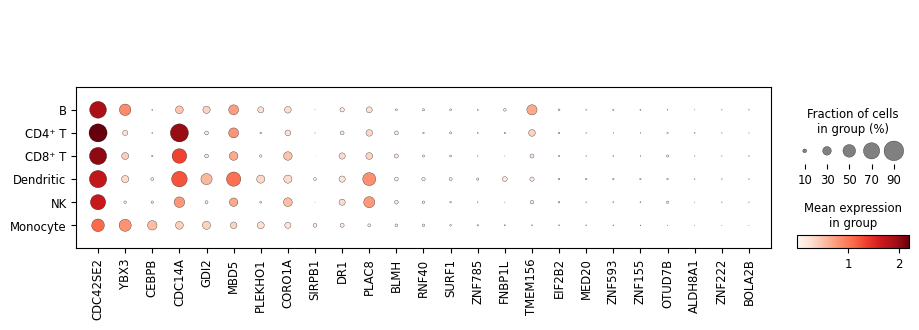

In [9]:
# What genes are present in eQTL data and not baseline
gained_genes = list(base_v_eqtl['gene'][base_v_eqtl['baseline'].isnull()])
print(f"Genes gained:\n{gained_genes}")
print(len(gained_genes))
monocyte_mask = adata.obs["celltype_imputed_lowerres"] == "monocyte"
adata_monocyte = adata[monocyte_mask, gained_genes]

mean_expr = adata_monocyte.X.mean(axis=0)
if hasattr(mean_expr, 'A1'):
    mean_expr = mean_expr.A1
else:
    mean_expr = np.asarray(mean_expr).flatten()

# Sort all gained genes by mean expression, no filtering
sorted_genes = [gene for _, gene in sorted(zip(mean_expr, gained_genes), reverse=True)]

sc.pl.dotplot(adata, var_names=sorted_genes, groupby='celltype_pretty')

<h2>Genes in baseline and not in eQTL</h2>

Genes gained:
['AC025048.4', 'AC068473.1', 'ACVR2A', 'AL121936.1', 'APOBEC3G', 'BRI3', 'CCDC153', 'CCND1', 'EFEMP2', 'LINC02373', 'LRRC8B', 'NFKB1', 'ORC4', 'PAFAH1B3', 'PRR19', 'PVR', 'SLC35D1', 'SLC38A9', 'SPACA6P-AS', 'SPECC1L', 'TAF8', 'YLPM1', 'ZNF629']
23


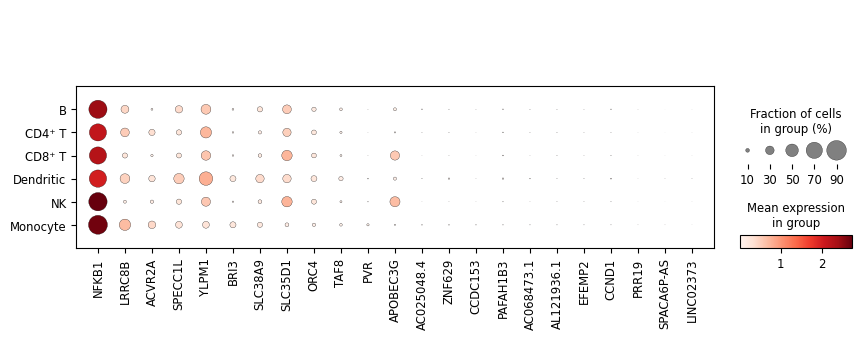

In [10]:
# What genes are present in baseline data and not eQTL
gained_genes = list(base_v_eqtl['gene'][base_v_eqtl['eqtl'].isnull()])
print(f"Genes gained:\n{gained_genes}")
print(len(gained_genes))
monocyte_mask = adata.obs["celltype_imputed_lowerres"] == "monocyte"
adata_monocyte = adata[monocyte_mask, gained_genes]

mean_expr = adata_monocyte.X.mean(axis=0)
if hasattr(mean_expr, 'A1'):
    mean_expr = mean_expr.A1
else:
    mean_expr = np.asarray(mean_expr).flatten()

# Sort all gained genes by mean expression, no filtering
sorted_genes = [gene for _, gene in sorted(zip(mean_expr, gained_genes), reverse=True)]

sc.pl.dotplot(adata, var_names=sorted_genes, groupby='celltype_pretty')


<h2>What genes are the gene descrepency</h2>

Genes gained:
['ALDH8A1', 'BLMH', 'CEBPB', 'CORO1A', 'GDI2', 'MED20', 'OTUD7B', 'PLAC8', 'RNF40', 'SIRPB1', 'TMEM156', 'ZNF155', 'ZNF593']
13


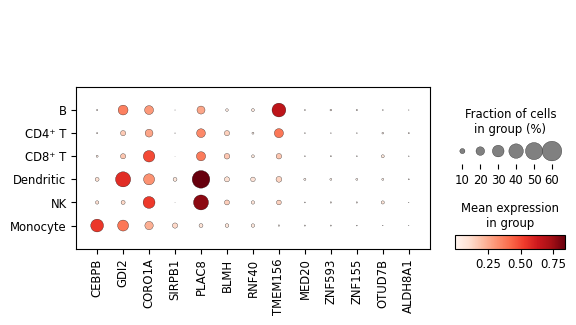

In [15]:
# What genes are present in baseline data and not eQTL
gained_genes = list(base_v_oc_eqtl['gene'][base_v_oc_eqtl['baseline'].isnull()])
print(f"Genes gained:\n{gained_genes}")
print(len(gained_genes))
monocyte_mask = adata.obs["celltype_imputed_lowerres"] == "monocyte"
adata_monocyte = adata[monocyte_mask, gained_genes]

mean_expr = adata_monocyte.X.mean(axis=0)
if hasattr(mean_expr, 'A1'):
    mean_expr = mean_expr.A1
else:
    mean_expr = np.asarray(mean_expr).flatten()

# Sort all gained genes by mean expression, no filtering
sorted_genes = [gene for _, gene in sorted(zip(mean_expr, gained_genes), reverse=True)]

sc.pl.dotplot(adata, var_names=sorted_genes, groupby='celltype_pretty')


Genes gained:
['AC025048.4', 'ACVR2A', 'AL121936.1', 'APOBEC3G', 'CCDC153', 'CCND1', 'NFKB1', 'ORC4', 'PRR19', 'SLC35D1', 'SLC38A9', 'TAF8']
12


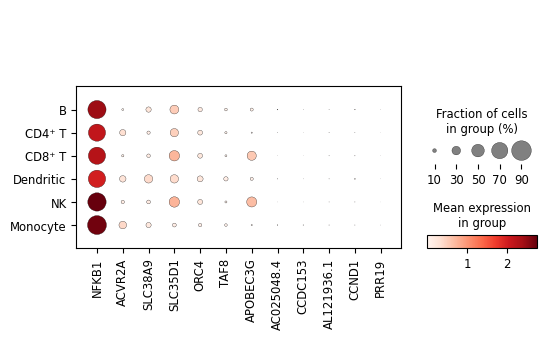

In [17]:
# What genes are present in baseline data and not eQTL
gained_genes = list(eqtl_v_oc_eqtl['gene'][eqtl_v_oc_eqtl['eqtl'].isnull()])
print(f"Genes gained:\n{gained_genes}")
print(len(gained_genes))
monocyte_mask = adata.obs["celltype_imputed_lowerres"] == "monocyte"
adata_monocyte = adata[monocyte_mask, gained_genes]

mean_expr = adata_monocyte.X.mean(axis=0)
if hasattr(mean_expr, 'A1'):
    mean_expr = mean_expr.A1
else:
    mean_expr = np.asarray(mean_expr).flatten()

# Sort all gained genes by mean expression, no filtering
sorted_genes = [gene for _, gene in sorted(zip(mean_expr, gained_genes), reverse=True)]

sc.pl.dotplot(adata, var_names=sorted_genes, groupby='celltype_pretty')


In [26]:
missing_in_eqtl = set(eqtl_v_oc_eqtl.loc[eqtl_v_oc_eqtl['eqtl'].isnull(), 'gene'])
missing_in_baseline = set(base_v_oc_eqtl.loc[base_v_oc_eqtl['baseline'].isnull(), 'gene'])

gained_eqtl = missing_in_eqtl | missing_in_baseline

In [27]:
gained_eqtl

{'AC025048.4',
 'ACVR2A',
 'AL121936.1',
 'ALDH8A1',
 'APOBEC3G',
 'BLMH',
 'CCDC153',
 'CCND1',
 'CEBPB',
 'CORO1A',
 'GDI2',
 'MED20',
 'NFKB1',
 'ORC4',
 'OTUD7B',
 'PLAC8',
 'PRR19',
 'RNF40',
 'SIRPB1',
 'SLC35D1',
 'SLC38A9',
 'TAF8',
 'TMEM156',
 'ZNF155',
 'ZNF593'}

In [31]:
eqtl_scores_file = "../Results/UT+24hCA_6ct_UT_nohvg/px_mono_count_eqtl/stats/mono_count_scores.csv"
baseline_scores_file = "../Results/UT+24hCA_6ct_UT_nohvg/px_mono_count_w10kb/stats/mono_count_scores.csv"

eqtl_scores = pd.read_csv(eqtl_scores_file)
base_scores = pd.read_csv(baseline_scores_file)

eqtl_scores = eqtl_scores.rename(columns={"norm_score": "norm_score_eqtl"})
base_scores = base_scores.rename(columns={"norm_score": "norm_score_base"})
    
merged_scores = eqtl_scores.merge(base_scores, on="cell_id")

merged_scores.head()

,cell_id,norm_score_eqtl,norm_score_base
0,AAGCAAGTCCTTGCAC_230105_lane1,0.405608,0.263105
1,CTAAGTCAGGGTGAAC_230105_lane1,1.455734,1.235080
2,CATTGTGCACCAGGTT_230105_lane1,2.280626,2.445499
3,CTGTTGGAGTGACCTG_230105_lane1,1.128041,1.083363
4,TAATGCATCTCACATT_230105_lane1,-1.434407,-1.289027


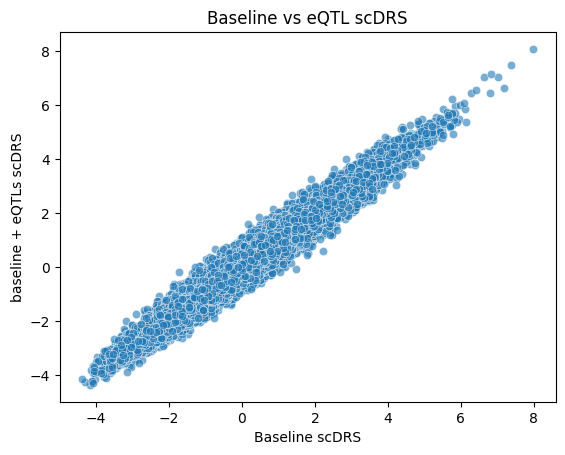

In [33]:
sns.scatterplot(
    data=merged_scores,
    x='norm_score_base',
    y='norm_score_eqtl',
    alpha=0.6
)
plt.xlabel('Baseline scDRS')
plt.ylabel('baseline + eQTLs scDRS')
plt.title('Baseline vs eQTL scDRS')
plt.show()
# print(merged_scores[["norm_score_base","norm_score_eqtl"]].corr())

### Conclusion
The strongest evidence for genes related to monocyte count is for NFKB1 and CEBPB, which means that its a tradeoff. Its difficult to say which of these is more important, and in the grand scheme of things the difference beteen them is probably negligable. The expression differences show the most potential for CEBPB as this gene seems tot show the greatest expression difference between monocytes and the rest of the PBMCs. eQTLs in open chromatine has both of these genes.


<h4> Genes gained/lost: eqtls in open chromatine vs baseline

Genes gained:
['ALDH8A1', 'BLMH', 'CEBPB', 'CORO1A', 'GDI2', 'MED20', 'OTUD7B', 'PLAC8', 'RNF40', 'SIRPB1', 'TMEM156', 'ZNF155', 'ZNF593']
13


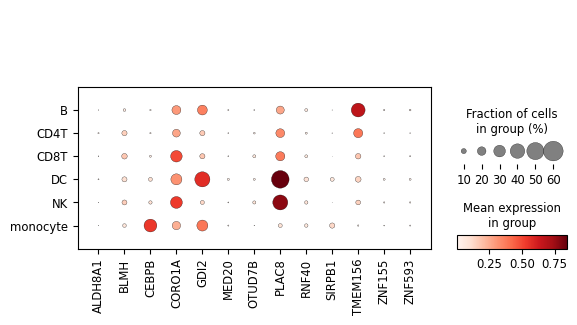

In [70]:
# What genes are Gained
gained_genes = list(base_v_oc_eqtl['gene'][base_v_oc_eqtl['baseline'].isnull()])
print(f"Genes gained:\n{gained_genes}")
print(len(gained_genes))
sc.pl.dotplot(adata, var_names=gained_genes, groupby='celltype_imputed_lowerres')

In [73]:
base_v_oc_eqtl

,gene,baseline,eqtl_oc
38,AC068473.1,7.8270,NaN
133,ALDH8A1,NaN,9.0260
165,BLMH,NaN,9.0219
169,BRI3,7.9388,NaN
216,CEBPB,NaN,10.0000
232,CORO1A,NaN,9.3324
281,EFEMP2,7.8163,NaN
319,GDI2,NaN,8.0259
448,LINC02373,7.8357,NaN
456,LRRC8B,7.8137,NaN


Genes lost:
['AC068473.1', 'BRI3', 'EFEMP2', 'LINC02373', 'LRRC8B', 'PAFAH1B3', 'PVR', 'SPACA6P-AS', 'SPECC1L', 'YLPM1', 'ZNF629']
11


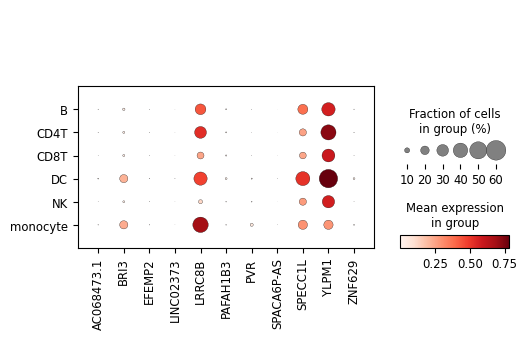

In [72]:
lost_genes = list(base_v_oc_eqtl['gene'][base_v_oc_eqtl['eqtl_oc'].isnull()])
print(f"Genes lost:\n{lost_genes}")
print(len(lost_genes))
sc.pl.dotplot(adata, var_names=lost_genes, groupby='celltype_imputed_lowerres')

<H2>Multiple Sclerosis</H2>

In [8]:
all_ms_scores = {
    "eqtl" : data_dir / "PascalX/gene_scores/all_eqtls/Multiple_sclerosis_GWAS_gscores.tsv",
    "eqtl_oc" : data_dir / "PascalX/gene_scores/oc_eqtls/Multiple_sclerosis_GWAS_gscores.tsv",
    "baseline" : data_dir / "PascalX/gene_scores/window_10000/Multiple_sclerosis_GWAS_gscores.tsv"
}
# Genesets (top 1000 genes, processed by scDRS munge-gs)
ms_gs_paths = {
    "eqtl" : data_dir / "SCDRS/genesets/px_multiple_sclerosis_eqtl.gs",
    "eqtl_oc" : data_dir / "SCDRS/genesets/px_multiple_sclerosis_eqtl_oc.gs",
    "baseline" : data_dir / "SCDRS/genesets/px_multiple_sclerosis_w10kb.gs"
}

In [9]:
# Initialize dict
ms_gs_data = {}

# All PascalX gene scores
for gs_name, file_path in all_ms_scores.items():
    df = pd.read_csv(file_path, sep="\t")
    merged_df = df.merge(
        gene_ref_df[['feature_id', 'start', 'chromosome']],
        left_on="gene",
        right_on="feature_id",
        how="left"
    )
    all_ms_scores[gs_name] = merged_df

# Read and process genesets (top 1000 genes)
for gs_name, file_path in ms_gs_paths.items():
    with open(file_path) as f:
        f.readline()
        data = f.readline().split()[1].split(",")
        gene_scores = [(gene.strip(), float(z)) for gene_data in data if gene_data for gene, z in [gene_data.split(":")]]
        
        df = pd.DataFrame(gene_scores, columns=['gene', 'z_score'])
        merged = df.merge(gene_ref_df, left_on="gene", right_on="feature_id", how="left")

        ms_gs_data[gs_name] = merged[[ "gene", "ENSG", "z_score", "chromosome", "start" ]]

ms_gs_data["eqtl"]

,gene,ENSG,z_score,chromosome,start
0,HLA-DRA,ENSG00000204287,10.0000,6,32439842
1,AL662884.4,ENSG00000285085,10.0000,6,32150495
2,PRRT1,ENSG00000204314,10.0000,6,32148359
3,PPT2,ENSG00000221988,10.0000,6,32153441
4,C6orf10,ENSG00000204296,10.0000,6,32288526
...,...,...,...,...,...
995,AP003501.1,ENSG00000254568,2.5038,11,124883691
996,SLC17A3,ENSG00000124564,2.5022,6,25833066
997,PUS10,ENSG00000162927,2.4999,2,60940222
998,AC245052.1,ENSG00000223660,2.4996,19,54199454


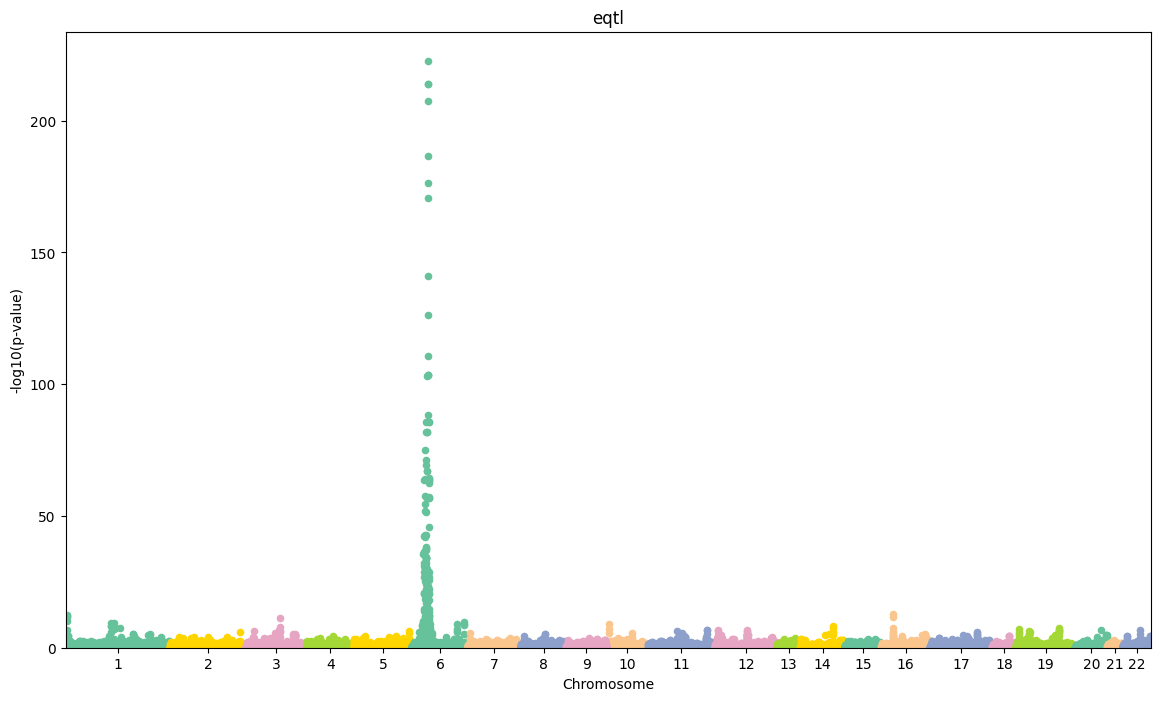

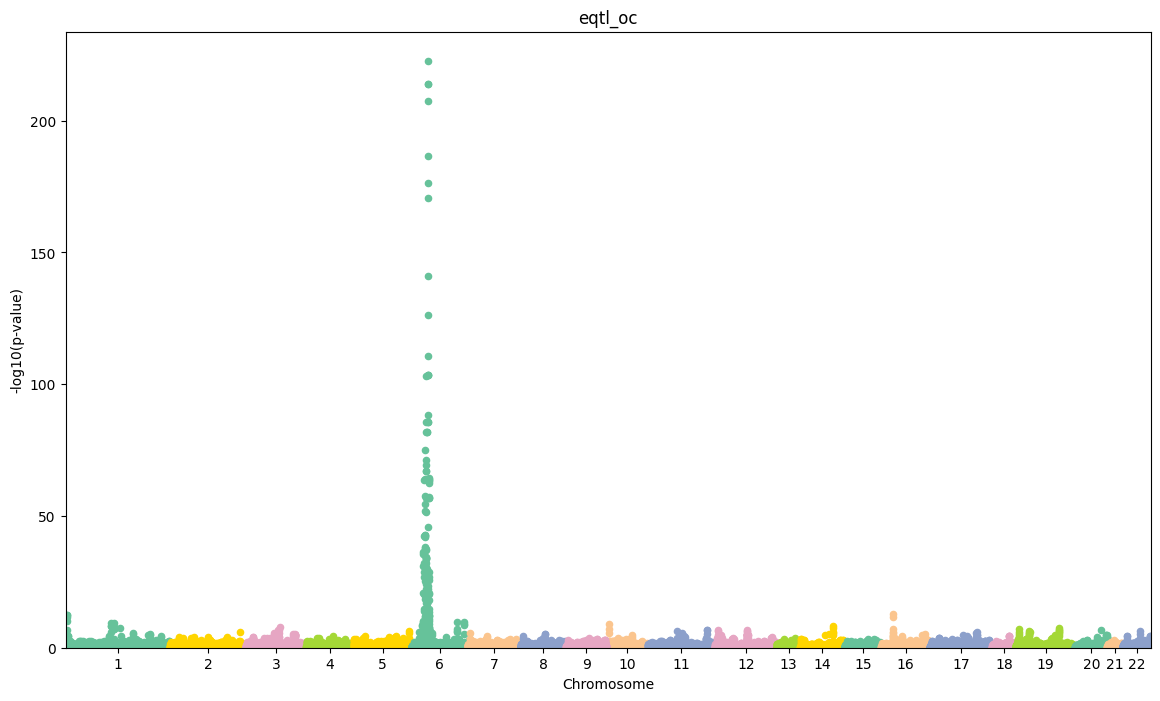

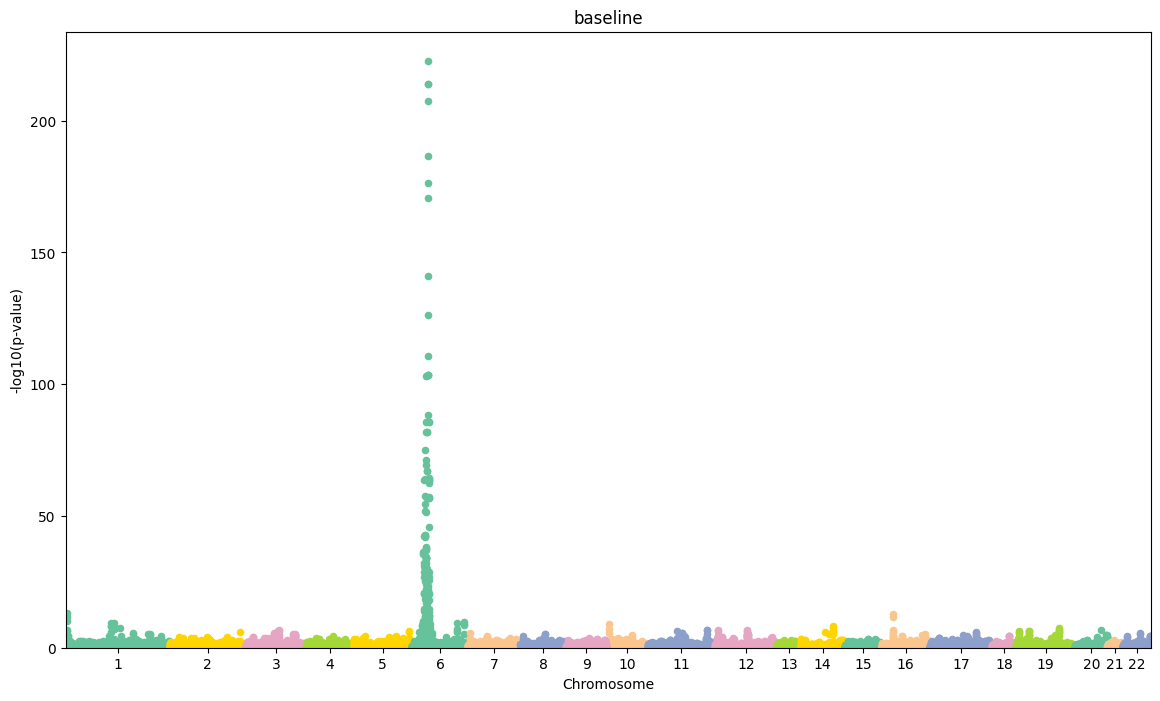

In [10]:
# Manhattan plots
colors = [
    "#66C29A",  # light green
    "#FBC58E",  # warm orange
    "#8CA0CB",  # light blue
    "#E6A6C3",  # light pink
    "#A4D836",  # light lime
    "#FFD500"   # golden yellow
]

for gs, df in all_ms_scores.items():

    # -log10(P)
    df['-log10(P)'] = -np.log10(df['pvalue'])
    
    # Create a cumulative position
    df['ind'] = range(len(df))
    df_grouped = df.groupby('chromosome')
    
    # Plot
    fig = plt.figure(figsize=(14, 8)) # Set the figure size
    ax = fig.add_subplot(111)
    x_labels = []
    x_labels_pos = []
    
    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='-log10(P)', color=colors[num % len(colors)], ax=ax)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] + group['ind'].iloc[0]) / 2)
    
    ax.set_xlim(df['ind'].iloc[0], df['ind'].iloc[-1])
    ax.set_ylim(bottom=0)
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('-log10(p-value)')
    plt.title(gs)
    plt.show()

In [13]:
eqtl_genes = list(ms_gs_data["eqtl"]["gene"])
ctrl_genes = list(ms_gs_data["baseline"]["gene"])
eqtl_oc_genes = list(ms_gs_data["eqtl_oc"]["gene"])

dicrepant_oc_eqtl = [gene for gene in eqtl_oc_genes if gene not in ctrl_genes]
dicrepant_eqtl = [gene for gene in eqtl_genes if gene not in ctrl_genes]
discrepant = [gene for gene in eqtl_genes if gene not in eqtl_oc_genes]

In [14]:
dicrepant_oc_eqtl

['IL12RB1',
 'HCAR2',
 'KNOP1',
 'ZCRB1',
 'PPP1R14B',
 'ABCB9',
 'TOP3B',
 'PTGER4',
 'GPR183',
 'CCDC88B',
 'POLR3H',
 'YAF2',
 'FCRL5',
 'C2orf74',
 'TEN1',
 'MNT',
 'RAB34',
 'NDUFS5',
 'DGKQ',
 'USP34',
 'NAA25',
 'IFRD2',
 'MCL1',
 'SRR',
 'ANKRD33B',
 'TRAV4',
 'JAML',
 'FGD6']

### 